In [ ]:
![title](../images/banner.png)

With this code you can:

1. download MODIS, NOAA and SNPP fire detections from NASA FIRMS for an area of interest and view them by confidence
2. merge them and add attributes to determine if the fire is in a forest concession, protected area, peatland
3. view the data and preliminary analysis
4. export and upload to Google drive for further analysis and visualisation
5. export fires in peatland classes to geoJSON for validation in Open Foris Ground

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import font_manager
import geopandas as gpd
from shapely.geometry import box
import rasterio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from shapely.geometry import Point
import geemap.foliumap as geemap
import folium
from folium.plugins import HeatMap
import ee
from datetime import datetime
from datetime import datetime, timedelta
import time
import geemap
import gspread
import warnings
from io import StringIO
import json
from tqdm import tqdm
from rasterio.sample import sample_gen
from pathlib import Path
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google.oauth2.credentials import Credentials

#from gspread_dataframe import set_with_dataframe
#from google_auth_oauthlib.flow import InstalledAppFlow

In [2]:
# Generate today's date in YYYY-DD-MM format
today = datetime.now().strftime("%Y-%d-%m")

In [3]:
# authorize upload to Google Drive
cred_path = Path.home() / ".config/earthengine/credentials"
with open(cred_path, "r") as f:
    access_token = json.load(f).get("access_token")
drive = build('drive', 'v3', credentials=Credentials(token=access_token))

you need to download this key from [NASA FIRMS]('https://firms.modaps.eosdis.nasa.gov/api/map_key/')

In [4]:
MAP_KEY = "771e84eed296daa55b4f920788623b7c"

In [5]:
# query data_availability to find out what date range is available for various datasets
# this url will return information about all supported sensors and their corresponding datasets
# instead of 'all' you can specify individual sensor, ex:LANDSAT_NRT
da_url = 'https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/' + MAP_KEY + '/all'
firms_data = pd.read_csv(da_url)
display(firms_data)

data_id    min_date    max_date
0          MODIS_NRT  2025-08-01  2025-10-22
1           MODIS_SP  2000-11-01  2025-07-31
2   VIIRS_NOAA20_NRT  2025-07-01  2025-10-22
3    VIIRS_NOAA20_SP  2018-04-01  2025-06-30
4   VIIRS_NOAA21_NRT  2024-01-17  2025-10-22
5     VIIRS_SNPP_NRT  2025-07-01  2025-10-22
6      VIIRS_SNPP_SP  2012-01-20  2025-06-30
7        LANDSAT_NRT  2022-06-20  2025-10-21
8           GOES_NRT  2022-08-09  2025-10-22
9           BA_MODIS  2000-11-01  2025-07-01
10          BA_VIIRS  2012-03-01  2025-07-01

In [6]:
aoi = gpd.read_file("/home/sepal-user/Peatlands_Congo/gis_data/Peatlands_AOI.shp")

In [7]:
# Get the bounding box of the AOI(minx, miny, maxx, maxy)
minx, miny, maxx, maxy = aoi.total_bounds
bbox = f"{minx},{miny},{maxx},{maxy}"
print(bbox)

14.99932372421427,-5.0016134989061865,25.728357392028784,3.30645703301439


In [8]:
# date from which to collect fire observations
start_date = "2025-01-01"

##### Land use and administrative areas

In [23]:
ADM1 = gpd.read_file("/home/sepal-user/Peatlands_Congo/gis_data/peatlands_adm1_aoi.shp")
PAs =gpd.read_file("/home/sepal-user/Peatlands_Congo/gis_data/peatlands_PAs.shp")
CONC_COD  = gpd.read_file("/home/sepal-user/Peatlands_Congo/gis_data/forest_concessions_COD.shp")
CONC_COG  = gpd.read_file("/home/sepal-user/Peatlands_Congo/gis_data/forest_concessions_COG.shp")

#### 1. get fire data

In [10]:
SOURCE = 'VIIRS_SNPP_NRT'

DAY_RANGE = 10
END_DATE  = datetime.utcnow()     # loop backward from today
END_DATE = datetime.strptime('2025-10-21', "%Y-%m-%d") # if there are no data yet as of today
STOP_DATE = firms_data.loc[firms_data['data_id'] == SOURCE, 'min_date'].values[0]
STOP_DATE = datetime.strptime(STOP_DATE, "%Y-%m-%d")  # ✅ convert string → datetime
#STOP_DATE = datetime.strptime('2025-09-01', "%Y-%m-%d")
all_SNPP_dfs = []

# --------------------------------------------------------------------
# LOOP BACKWARD IN 10-DAY PERIODS
# --------------------------------------------------------------------
current_end = END_DATE
while current_end > STOP_DATE:
    end_str = current_end.strftime("%Y-%m-%d")

    # FIRMS syntax: /area/csv/<MAP_KEY>/<SOURCE>/<BBOX>/<DAY_RANGE>/<END_DATE>
    url = (
        f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/"
        f"{MAP_KEY}/{SOURCE}/{bbox}/{DAY_RANGE}/{end_str}"
    )

    print(f"🔹 Requesting {DAY_RANGE} days ending {end_str}")

    try:
        r = requests.get(url, timeout=60)
        if r.status_code == 200 and len(r.text.strip()) > 0:
            df = pd.read_csv(StringIO(r.text))
            if not df.empty:
                # ✅ Filter out low-confidence fires
                if "confidence" in df.columns:
                    df = df[df["confidence"].str.lower() != "l"]

                if not df.empty:
                    print(f"✅ Retrieved {len(df)} high/nominal confidence records")
                    all_SNPP_dfs.append(df)
                else:
                    print("⚠️  Only low-confidence detections, skipped.")
            else:
                print("⚠️  No data for this interval.")
        else:
            print(f"⚠️  HTTP {r.status_code} — skipping.")
    except Exception as e:
        print(f"❌ Error: {e}")

    # Step back 10 days
    current_end -= timedelta(days=DAY_RANGE)
    time.sleep(2)  # polite pause to respect FIRMS rate limits

# --------------------------------------------------------------------
# Combine and tag all results
# --------------------------------------------------------------------
if all_SNPP_dfs:
    all_SNPP = pd.concat(all_SNPP_dfs, ignore_index=True).drop_duplicates()
    all_SNPP["satellite"] = "SNPP"
    print(f"\n🔥 Total combined records (excluding low-confidence): {len(all_SNPP)}")

🔹 Requesting 10 days ending 2025-10-21
✅ Retrieved 77 high/nominal confidence records
🔹 Requesting 10 days ending 2025-10-11
✅ Retrieved 1503 high/nominal confidence records
🔹 Requesting 10 days ending 2025-10-01
✅ Retrieved 3156 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-21
✅ Retrieved 5305 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-11
✅ Retrieved 12015 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-01
✅ Retrieved 26528 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-22
✅ Retrieved 55953 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-12
✅ Retrieved 61228 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-02
✅ Retrieved 35024 high/nominal confidence records
🔹 Requesting 10 days ending 2025-07-23
✅ Retrieved 30544 high/nominal confidence records
🔹 Requesting 10 days ending 2025-07-13
✅ Retrieved 15885 high/nominal confidence records
🔹 Requesting 10 days ending

In [11]:
all_SNPP.head()

latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  -3.09468   15.00297      303.01  0.54   0.42  2025-10-21         7   
1  -3.08773   15.00945      329.43  0.54   0.42  2025-10-21         7   
2  -1.37423   16.54004      309.87  0.47   0.40  2025-10-21         7   
3  -0.30853   15.53946      300.44  0.55   0.43  2025-10-21         7   
4   0.39523   15.22947      301.11  0.39   0.44  2025-10-21         7   

  satellite instrument confidence version  bright_ti5   frp daynight  
0      SNPP      VIIRS          n  2.0NRT      289.49  1.39        N  
1      SNPP      VIIRS          n  2.0NRT      289.94  4.31        N  
2      SNPP      VIIRS          n  2.0NRT      288.83  1.28        N  
3      SNPP      VIIRS          n  2.0NRT      287.62  0.44        N  
4      SNPP      VIIRS          n  2.0NRT      288.14  0.37        N

In [12]:
SOURCE = 'VIIRS_NOAA20_NRT'

DAY_RANGE = 10
END_DATE  = datetime.utcnow()     # loop backward from today
END_DATE = datetime.strptime('2025-10-21', "%Y-%m-%d") # if there are no data yet as of today
#get VIIRS_NRT start date from table
STOP_DATE = firms_data.loc[firms_data['data_id'] == SOURCE, 'min_date'].values[0]
STOP_DATE = datetime.strptime(STOP_DATE, "%Y-%m-%d")  # ✅ convert string → datetime
# for shorter time processing
#STOP_DATE = datetime.strptime('2025-09-01', "%Y-%m-%d")

all_NOAA20_dfs = []

# --------------------------------------------------------------------
# LOOP BACKWARD IN 10-DAY PERIODS
# --------------------------------------------------------------------
current_end = END_DATE
while current_end > STOP_DATE:
    end_str = current_end.strftime("%Y-%m-%d")

    # FIRMS syntax: /area/csv/<MAP_KEY>/<SOURCE>/<BBOX>/<DAY_RANGE>/<END_DATE>
    url = (
        f"https://firms.modaps.eosdis.nasa.gov/api/area/csv/"
        f"{MAP_KEY}/{SOURCE}/{bbox}/{DAY_RANGE}/{end_str}"
    )

    print(f"🔹 Requesting {DAY_RANGE} days ending {end_str}")

    try:
        r = requests.get(url, timeout=60)
        if r.status_code == 200 and len(r.text.strip()) > 0:
            df = pd.read_csv(StringIO(r.text))
            if not df.empty:
                # ✅ Filter out low-confidence detections
                if "confidence" in df.columns:
                    df = df[df["confidence"].str.lower() != "l"]

                if not df.empty:
                    print(f"✅ Retrieved {len(df)} high/nominal confidence records")
                    all_NOAA20_dfs.append(df)
                else:
                    print("⚠️  Only low-confidence detections, skipped.")
            else:
                print("⚠️  No data for this interval.")
        else:
            print(f"⚠️  HTTP {r.status_code} — skipping.")
    except Exception as e:
        print(f"❌ Error: {e}")

    # Step back 10 days
    current_end -= timedelta(days=DAY_RANGE)
    time.sleep(2)  # polite pause to respect FIRMS rate limits

# --------------------------------------------------------------------
# Combine and tag all results
# --------------------------------------------------------------------
if all_NOAA20_dfs:
    all_NOAA20 = pd.concat(all_NOAA20_dfs, ignore_index=True).drop_duplicates()
    all_NOAA20["satellite"] = "NOAA20"
    print(f"\n🔥 Total combined records (excluding low-confidence): {len(all_NOAA20)}")

🔹 Requesting 10 days ending 2025-10-21
✅ Retrieved 159 high/nominal confidence records
🔹 Requesting 10 days ending 2025-10-11
✅ Retrieved 1562 high/nominal confidence records
🔹 Requesting 10 days ending 2025-10-01
✅ Retrieved 3166 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-21
✅ Retrieved 5189 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-11
✅ Retrieved 12095 high/nominal confidence records
🔹 Requesting 10 days ending 2025-09-01
✅ Retrieved 20842 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-22
✅ Retrieved 43060 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-12
✅ Retrieved 56433 high/nominal confidence records
🔹 Requesting 10 days ending 2025-08-02
✅ Retrieved 35143 high/nominal confidence records
🔹 Requesting 10 days ending 2025-07-23
✅ Retrieved 29041 high/nominal confidence records
🔹 Requesting 10 days ending 2025-07-13
✅ Retrieved 13921 high/nominal confidence records
🔹 Requesting 10 days endin

In [13]:
all_NOAA20.head()

latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  -0.32204   15.53911      305.32  0.40   0.37  2025-10-21        28   
1   0.39705   15.22755      300.62  0.39   0.36  2025-10-21        28   
2   1.42826   16.17601      302.89  0.41   0.37  2025-10-21        28   
3   2.62688   16.06451      305.34  0.40   0.37  2025-10-21        28   
4   2.63025   16.06505      313.94  0.40   0.37  2025-10-21        28   

  satellite instrument confidence version  bright_ti5   frp daynight  
0    NOAA20      VIIRS          n  2.0NRT      287.84  0.83        N  
1    NOAA20      VIIRS          n  2.0NRT      288.92  0.81        N  
2    NOAA20      VIIRS          n  2.0NRT      283.68  0.68        N  
3    NOAA20      VIIRS          n  2.0NRT      288.95  1.18        N  
4    NOAA20      VIIRS          n  2.0NRT      290.03  1.18        N

##### combine all fire detections

In [14]:
# Combine
merged_fires = pd.concat([all_NOAA20, all_SNPP], ignore_index=True)

merged_fires_gdf = gpd.GeoDataFrame(
    merged_fires,
    geometry=gpd.points_from_xy(merged_fires.longitude, merged_fires.latitude),
    crs="EPSG:4326"
)
len(merged_fires_gdf)

489302

In [15]:
#remove any duplicates
# Make sure acq_date is a proper datetime
merged_fires_gdf["acq_date"] = pd.to_datetime(merged_fires_gdf["acq_date"])

# Sort by date descending so newest is first
merged_fires_gdf = merged_fires_gdf.sort_values("acq_date", ascending=False)

# Drop duplicates by coordinates, keeping the most recent
fires_unique = merged_fires_gdf.drop_duplicates(subset=["latitude", "longitude"], keep="first")

print(f"🔥 Unique fire detections: {len(fires_unique)}")

🔥 Unique fire detections: 489301


#### 2. extract and add attributes

In [16]:
# Ensure same CRS
if merged_fires_gdf.crs != ADM1.crs:
    merged_fires_gdf = merged_fires_gdf.to_crs(ADM1.crs)

# Combine all AOI geometries
try:
    ADM1 = ADM1.union_all()       # new method (GeoPandas >= 0.14)
except AttributeError:
    ADM1 = ADM1.unary_union       # fallback for older GeoPandas versions

# Filter fires within AOI
fires_within_adm1 = merged_fires_gdf[merged_fires_gdf.geometry.within(ADM1)]

print(f"🔥 Fires within ADM1: {len(fires_within_adm1)}")

🔥 Fires within ADM1: 339291


##### add peatlands classes from GEE asset (very slow - not recommended)

In [ ]:
# Initialize Earth Engine
#ee.Initialize()

In [ ]:
#PEAT_TYPES = ee.Image('projects/congopeatlands/assets/LandCover_Crezee_2022')

In [17]:
"""
# get peatlands classes for each fire
fires_within_adm1 = fires_within_adm1.reset_index().rename(columns={"index": "UID"})
UID = 'UID'

fires_fc = geemap.gdf_to_ee(fires_within_adm1[['UID', 'geometry']])

total = fires_within_adm1.shape[0]
print(f"🔥 Sampling {total:,} points...")

# ---------------------------------------------------------
# 2️⃣ Chunk into manageable batches (e.g., 50k each)
# ---------------------------------------------------------
BATCH_SIZE = 90000
n_batches = (total // BATCH_SIZE) + 1

dfs = []

for i in range(n_batches):
    print(f"\n🧩 Processing batch {i+1}/{n_batches} ...")
    
    # Subset points using limit() and skip()
    subset = fires_fc.limit(BATCH_SIZE, i * BATCH_SIZE)

    # Sample raster values
    sampled_fc = PEAT_TYPES.select('b1').sampleRegions(
        collection=subset,
        scale=375,
        geometries=False  # don't include geometry, makes it faster
    )

    # Convert to GeoDataFrame (or plain DataFrame)
    tmp_df = geemap.ee_to_gdf(sampled_fc)
    dfs.append(tmp_df)
    print(f"✅ Retrieved {len(tmp_df)} rows")

# ---------------------------------------------------------
# 3️⃣ Combine all local chunks
# ---------------------------------------------------------
sampled_fires = pd.concat(dfs, ignore_index=True)
print(f"\n✅ Combined {len(sampled_fires)} sampled points")
"""

'\n# get peatlands classes for each fire\nfires_within_adm1 = fires_within_adm1.reset_index().rename(columns={"index": "UID"})\nUID = \'UID\'\n\nfires_fc = geemap.gdf_to_ee(fires_within_adm1[[\'UID\', \'geometry\']])\n\ntotal = fires_within_adm1.shape[0]\nprint(f"🔥 Sampling {total:,} points...")\n\n# ---------------------------------------------------------\n# 2️⃣ Chunk into manageable batches (e.g., 50k each)\n# ---------------------------------------------------------\nBATCH_SIZE = 90000\nn_batches = (total // BATCH_SIZE) + 1\n\ndfs = []\n\nfor i in range(n_batches):\n    print(f"\n🧩 Processing batch {i+1}/{n_batches} ...")\n    \n    # Subset points using limit() and skip()\n    subset = fires_fc.limit(BATCH_SIZE, i * BATCH_SIZE)\n\n    # Sample raster values\n    sampled_fc = PEAT_TYPES.select(\'b1\').sampleRegions(\n        collection=subset,\n        scale=375,\n        geometries=False  # don\'t include geometry, makes it faster\n    )\n\n    # Convert to GeoDataFrame (or plain 

In [ ]:
#merged = merged.rename(columns={'first':'Peat_Class_Code'})
#merged.head()

In [ ]:
# merge back with fires by UID
#merged = fires_within_adm1.merge(sampled_fires[['UID', 'b1']], on='UID', how='left')

##### add peat classes from raster dataset in SEPAL 

In [18]:
peat_types = "/home/sepal-user/Peatlands_Congo/gis_data/Crezee_2022_class_100m_4bit.tif"

with rasterio.open(peat_types) as src:
    # Match coordinate systems
    fires_within_adm1 = fires_within_adm1.to_crs(src.crs)

    # Prepare coordinates
    coords = [(geom.x, geom.y) for geom in fires_within_adm1.geometry]

    # Sample in batches
    batch_size = 50000
    peat_vals = []
    for i in tqdm(range(0, len(coords), batch_size), desc="Sampling"):
        batch_coords = coords[i:i+batch_size]
        peat_vals.extend([val[0] if val else np.nan for val in src.sample(batch_coords)])

# --- Add results to GeoDataFrame ---
fires_within_adm1["peat_class_code"] = peat_vals

Sampling: 100%|██████████| 7/7 [00:10<00:00,  1.45s/it]


In [19]:
peat_class_names = {
    1: "water",
    2: "savanna",
    3: "terra firme forest",
    4: "palm dominated swamp",
    5: "hardwood dominated swamp"
}

# Map numeric codes to labels
fires_within_adm1["peat_class_name"] = fires_within_adm1["peat_class_code"].map(peat_class_names)

# Replace where code == 0 or NaN
fires_within_adm1.loc[
    fires_within_adm1["peat_class_code"].isna() | (fires_within_adm1["peat_class_code"] == 0),
    "peat_class_name"
] = "no data"

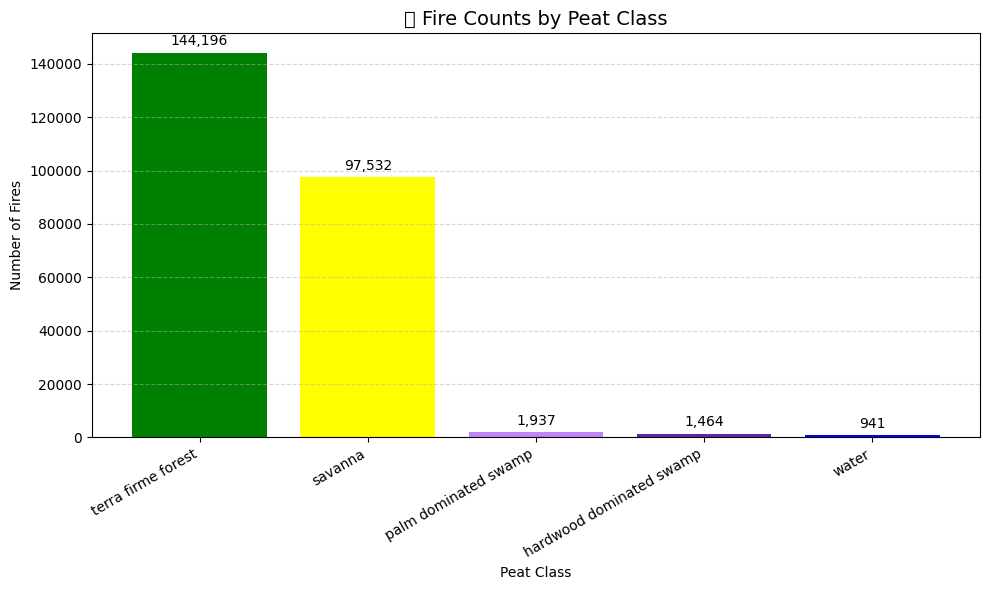

In [25]:
warnings.filterwarnings("ignore", message="Glyph 128293")
# --- Count fires by peat class (including NaN) ---
peat_counts = (
    fires_within_adm1["peat_class_name"]
    .value_counts(dropna=False)
    .rename_axis("Peat Class")
    .reset_index(name="Fire Count")
)

# Replace NaN with "No Data"
peat_counts["Peat Class"] = peat_counts["Peat Class"].fillna("No Data")

# --- Define color mapping ---
color_map = {
    "terra firme forest": "green",
    "savanna": "yellow",
    "no data": "grey",
    "palm dominated swamp": "#c084fc",   # light purple
    "hardwood dominated swamp": "#6b21a8",  # dark purple
    "water":"blue"
}

# --- Map colors (default grey for unknowns) ---
peat_counts["Color"] = peat_counts["Peat Class"].str.lower().map(color_map).fillna("grey")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    peat_counts["Peat Class"],
    peat_counts["Fire Count"],
    color=peat_counts["Color"]
)

# --- Add labels on bars ---
ax.bar_label(bars, labels=[f"{v:,}" for v in peat_counts["Fire Count"]],
             label_type="edge", padding=3, fontsize=10, color="black")

# --- Style ---
ax.set_title("🔥 Fire Counts by Peat Class", fontsize=14)
ax.set_xlabel("Peat Class")
ax.set_ylabel("Number of Fires")
plt.xticks(rotation=30, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [26]:
# Remove rows where peat_class_name is "No Data" or NaN
fires_within_adm1 = fires_within_adm1[
    fires_within_adm1["peat_class_name"].notna() & 
    (fires_within_adm1["peat_class_name"].str.lower() != "no data")
].copy()

print(f"Remaining records after filtering: {len(fires_within_adm1)}")
fires_within_adm1['peat_class_name'].value_counts()

Remaining records after filtering: 246070


peat_class_name
terra firme forest          144196
savanna                      97532
palm dominated swamp          1937
hardwood dominated swamp      1464
water                          941
Name: count, dtype: int64

In [27]:
# --- Reproject all layers to match fire points ---
ADM1 = ADM1.to_crs(fires_within_adm1.crs)
PAs = PAs.to_crs(fires_within_adm1.crs)
CONC_COD = CONC_COD.to_crs(fires_within_adm1.crs)
CONC_COG = CONC_COG.to_crs(fires_within_adm1.crs)

# --- Define spatial join that only keeps specified columns ---
def spatial_join_custom_prefix(base_gdf, join_gdf, columns, prefix, predicate="intersects"):
    """
    Spatially join attributes from join_gdf to base_gdf, keeping only the specified columns.
    Adds a custom prefix to the joined columns.
    """
    # Keep only geometry and selected columns in the join layer
    keep_cols = ["geometry"] + [c for c in columns if c in join_gdf.columns]
    join_gdf = join_gdf[keep_cols].copy()

    # Drop Shape_Area if somehow still present
    if "Shape_Area" in join_gdf.columns:
        join_gdf.drop(columns=["Shape_Area"], inplace=True, errors="ignore")

    # Perform join
    joined = gpd.sjoin(base_gdf, join_gdf, how="left", predicate=predicate)

    # Rename and prefix the joined columns
    for col in columns:
        if col in joined.columns:
            joined.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

    # Drop index_right if created
    joined.drop(columns=["index_right"], inplace=True, errors="ignore")
    return joined

# --- Apply joins sequentially ---
fires_all_atts = spatial_join_custom_prefix(fires_within_adm1, ADM1, ["gaul1_name"], "ADM1")
fires_all_atts = spatial_join_custom_prefix(fires_all_atts, PAs, ["NAME"], "PA")
fires_all_atts = spatial_join_custom_prefix(fires_all_atts, CONC_COD, ["desc_type"], "for_conc_COD")
fires_all_atts = spatial_join_custom_prefix(fires_all_atts, CONC_COG, ["ste_att_en"], "for_conc_COG")

# --- Create indicator fields ---
fires_all_atts["PA"] = np.where(fires_all_atts["PA_NAME"].notna(), 1, 0)
fires_all_atts["for_conc_COD"] = np.where(fires_all_atts["for_conc_COD_desc_type"].notna(), 1, 0)
fires_all_atts["for_conc_COG"] = np.where(fires_all_atts["for_conc_COG_ste_att_en"].notna(), 1, 0)

fires_all_atts.head()

latitude  longitude  bright_ti4  scan  track   acq_date  acq_time  \
151   2.65086   17.18209      325.03  0.42   0.38 2025-10-22         7   
152   2.80658   18.02221      328.62  0.40   0.37 2025-10-22         7   
154   1.39681   16.32744      316.49  0.44   0.39 2025-10-22         9   
155   1.39909   16.33598      301.46  0.44   0.39 2025-10-22         9   
156   1.42768   16.17640      304.76  0.45   0.39 2025-10-22         9   

    satellite instrument confidence  ...                  geometry  \
151    NOAA20      VIIRS          n  ...  POINT (17.18209 2.65086)   
152    NOAA20      VIIRS          n  ...  POINT (18.02221 2.80658)   
154    NOAA20      VIIRS          n  ...  POINT (16.32744 1.39681)   
155    NOAA20      VIIRS          n  ...  POINT (16.33598 1.39909)   
156    NOAA20      VIIRS          n  ...   POINT (16.1764 1.42768)   

     peat_class_code     peat_class_name ADM1_gaul1_name PA_NAME  \
151              3.0  terra firme forest        Likouala     NaN   
152              3.0  terra firme forest        Likouala     NaN   
154              2.0             savanna          Sangha     NaN   
155              2.0             savanna          Sangha     NaN   
156              2.0             savanna          Sangha     NaN   

     for_conc_COD_desc_type for_conc_COG_ste_att_en PA for_conc_COD  \
151                     NaN            THANRY-CONGO  0            0   
152                     NaN                    SCTB  0            0   
154                     NaN                     CIB  0            0   
155                     NaN                     CIB  0            0   
156                     NaN                     IFO  0            0   

    for_conc_COG  
151            1  
152            1  
154            1  
155            1  
156            1  

[5 rows x 24 columns]

In [28]:
print("\n".join(fires_all_atts.columns))

latitude
longitude
bright_ti4
scan
track
acq_date
acq_time
satellite
instrument
confidence
version
bright_ti5
frp
daynight
geometry
peat_class_code
peat_class_name
ADM1_gaul1_name
PA_NAME
for_conc_COD_desc_type
for_conc_COG_ste_att_en
PA
for_conc_COD
for_conc_COG


#### 3. Evaluate and visualize

🔥 Fire detections by source:
  satellite  Fire Count
0      SNPP      130469
1    NOAA20      115601


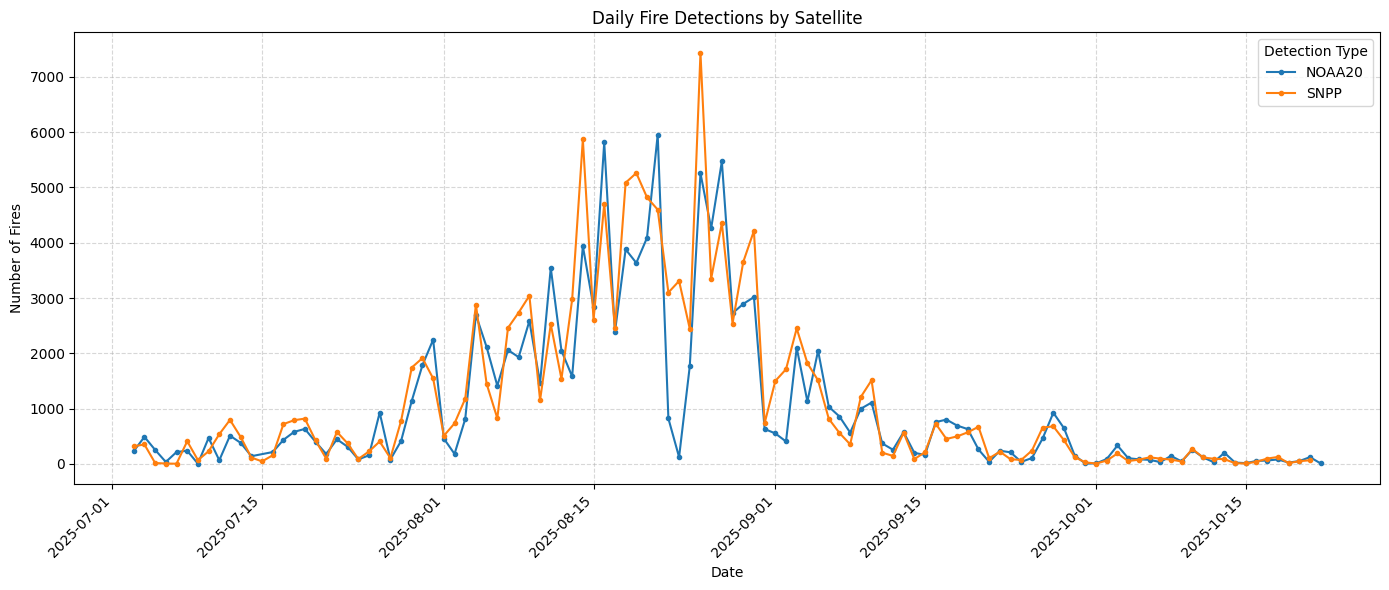

In [29]:
fire_counts = fires_all_atts["satellite"].value_counts().reset_index()
fire_counts.columns = ["satellite", "Fire Count"]

print("🔥 Fire detections by source:")
print(fire_counts)

fires_all_atts["acq_date"] = pd.to_datetime(fires_all_atts["acq_date"], errors="coerce")

daily_counts = fires_all_atts.groupby(["acq_date", "satellite"]).size().reset_index(name="Fire Count")

warnings.filterwarnings("ignore", message="Glyph .* missing from font")

plt.figure(figsize=(14, 6))
for src in daily_counts["satellite"].unique():
    data = daily_counts[daily_counts["satellite"] == src]
    plt.plot(data["acq_date"], data["Fire Count"], marker="o", markersize=3, label=src)

plt.title("Daily Fire Detections by Satellite")
plt.xlabel("Date")
plt.ylabel("Number of Fires")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Detection Type")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

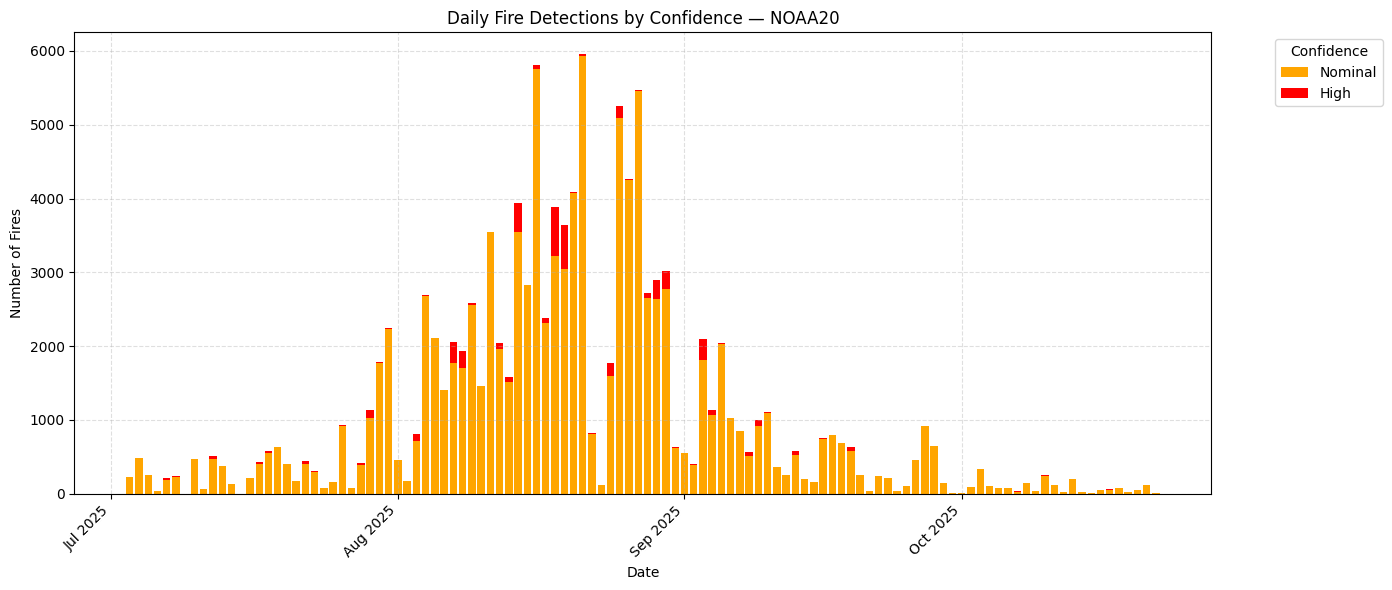

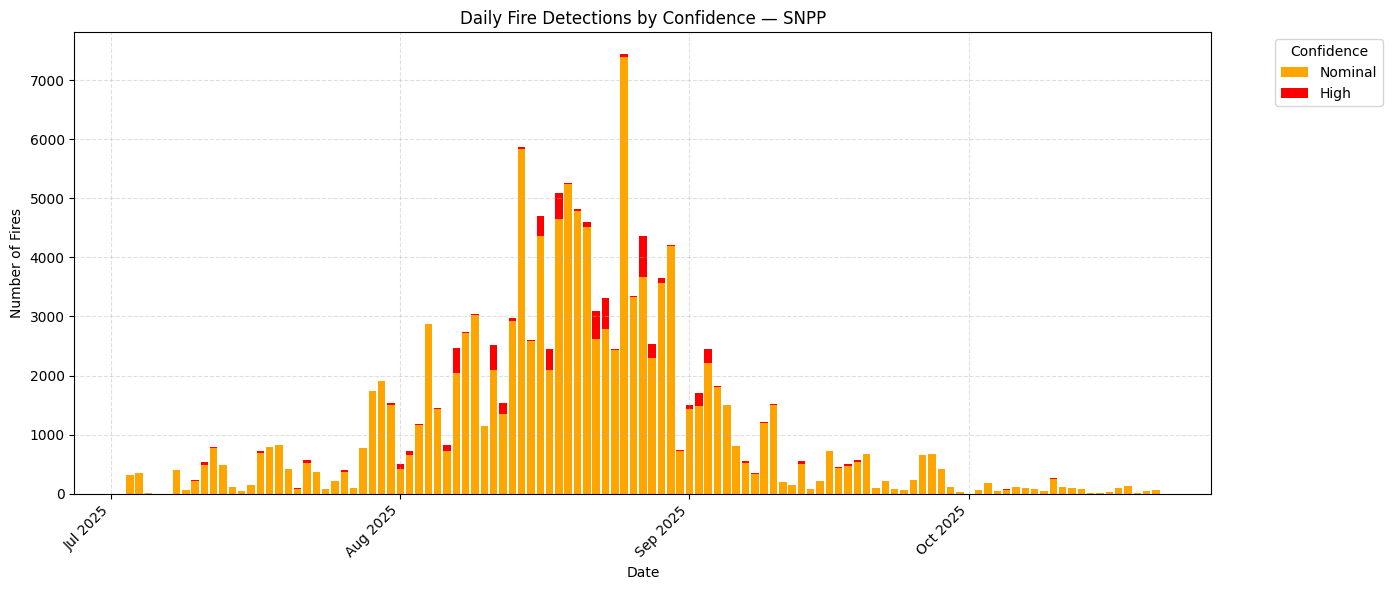

In [30]:
#plot confidence
fires_all_atts["acq_date"] = pd.to_datetime(fires_all_atts["acq_date"], errors="coerce")

confidence_order = ["n", "h"]
colors = {"n": "orange", "h": "red"}

satellites = fires_all_atts["satellite"].dropna().unique()

warnings.filterwarnings("ignore", message="Glyph .* missing from font")

for sat in satellites:
    # Filter for this satellite
    sat_df = fires_all_atts[fires_all_atts["satellite"] == sat]

    # Group by date and confidence
    daily_conf_counts = (
        sat_df.groupby(["acq_date", "confidence"])
        .size()
        .reset_index(name="Fire Count")
    )

    # Pivot to wide format
    pivot_df = daily_conf_counts.pivot(index="acq_date", columns="confidence", values="Fire Count").fillna(0)
    pivot_df = pivot_df.reindex(columns=[c for c in confidence_order if c in pivot_df.columns])

    # --- Plot stacked bars ---
    fig, ax = plt.subplots(figsize=(14, 6))
    bottom = pd.Series(0, index=pivot_df.index)
    for conf in pivot_df.columns:
        ax.bar(pivot_df.index, pivot_df[conf], bottom=bottom, color=colors.get(conf, "gray"), label=conf.capitalize())
        bottom += pivot_df[conf]

    # --- Style x-axis ---
    ax.xaxis.set_major_locator(mdates.MonthLocator())            # one tick per month
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # format month + year
    plt.xticks(rotation=45, ha="right")

    # --- Titles and labels ---
    plt.title(f"Daily Fire Detections by Confidence — {sat}")
    plt.xlabel("Date")
    plt.ylabel("Number of Fires")
    plt.legend(
        title="Confidence",
        labels=["Nominal", "High"],
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [31]:
#visualize in a map
# --- Ensure latitude/longitude columns exist ---
if not {"latitude", "longitude"}.issubset(fires_all_atts.columns):
    fires_all_atts["latitude"] = fires_all_atts.geometry.y
    fires_all_atts["longitude"] = fires_all_atts.geometry.x

# --- Prepare heatmap data ---
heat_data = fires_all_atts[["latitude", "longitude"]].dropna().values.tolist()

# --- Create map ---
m = folium.Map(
    location=[fires_all_atts.latitude.mean(), fires_all_atts.longitude.mean()],
    zoom_start=6,
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery"
)

# --- Custom blue → red gradient ---
custom_gradient = {
    0.0: "blue",
    0.25: "cyan",
    0.5: "lime",
    0.75: "yellow",
    1.0: "red"
}

# --- Add heatmap layer ---
HeatMap(
    heat_data,
    name="Fire Heatmap",
    radius=6,
    blur=10,
    min_opacity=0.4,
    gradient=custom_gradient
).add_to(m)

# --- Add ADM1 polygon layer (transparent fill, white borders) ---
if "ADM1" in locals() and ADM1 is not None:
    folium.GeoJson(
        ADM1,
        name="ADM1 Boundaries",
        style_function=lambda x: {
            "color": "white",
            "weight": 1,
            "fill": False
        }
    ).add_to(m)

# --- Add AOI layer (optional) ---
if "AOI" in locals() and AOI is not None:
    folium.GeoJson(
        AOI,
        name="AOI",
        style_function=lambda x: {"color": "blue", "weight": 2, "fill": False}
    ).add_to(m)

# --- Add legend ---
legend_html = """
<div style="
position: fixed;
bottom: 10px; left: 10px; width: 200px; height: 90px;
background-color: white; border:2px solid grey; z-index:9999; font-size:13px;
padding: 10px;">
<b>🔥 Fire Density</b><br>
<svg width="180" height="15">
  <defs>
    <linearGradient id="grad" x1="0%" y1="0%" x2="100%" y2="0%">
      <stop offset="0%" style="stop-color:blue;stop-opacity:1" />
      <stop offset="25%" style="stop-color:cyan;stop-opacity:1" />
      <stop offset="50%" style="stop-color:lime;stop-opacity:1" />
      <stop offset="75%" style="stop-color:yellow;stop-opacity:1" />
      <stop offset="100%" style="stop-color:red;stop-opacity:1" />
    </linearGradient>
  </defs>
  <rect width="180" height="15" fill="url(#grad)" />
</svg><br>
Low&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;High
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# --- Layer control ---
folium.LayerControl().add_to(m)

m

#### 4. upload results to Google Drive

In [32]:
#export to csv
# Build the filename with the date appended
output_path = f"/home/sepal-user/Peatlands_Congo/fires_VIIRS_{today}.csv"
# Export first to csv in SEPAL
fires_all_atts.to_csv(output_path, index_label='ID')

In [34]:
#Ensure Peatlands folder exists
folder_name = "Congo_Peatlands"
folder_results = drive.files().list(
    q=f"name='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false",
    fields="files(id, name)"
).execute()
folders = folder_results.get("files", [])

if not folders:
    print(f"⚠️ Folder '{folder_name}' not found. Creating it...")
    folder_metadata = {"name": folder_name, "mimeType": "application/vnd.google-apps.folder"}
    folder = drive.files().create(body=folder_metadata, fields="id").execute()
    folder_id = folder["id"]
    print(f"🆕 Created folder '{folder_name}' (ID: {folder_id})")
else:
    folder_id = folders[0]["id"]
    print(f"📁 Found folder '{folder_name}' (ID: {folder_id})")

⚠️ Folder 'Congo_Peatlands' not found. Creating it...
🆕 Created folder 'Congo_Peatlands' (ID: 14T1F67Oe_jorIKQk5hGVa-BvPcmJHoUg)


In [38]:
# Upload CSV to Drive folder
VIIRS_file_name = f"fires_VIIRS_{today}.csv"
VIIRS_file_metadata = {"name": VIIRS_file_name, "parents": [folder_id]}
media = MediaFileUpload(output_path, mimetype="text/csv", resumable=True)

# (Optional) Check if file with same name already exists and replace it
existing = drive.files().list(
    q=f"name='{VIIRS_file_name}' and '{folder_id}' in parents and trashed=false",
    fields="files(id, name)"
).execute()
files = existing.get("files", [])

if files:
    file_id = files[0]["id"]
    print(f"♻️ Replacing existing file '{VIIRS_file_name}'...")
    updated = drive.files().update(fileId=file_id, media_body=media).execute()
    file_id = updated["id"]
else:
    uploaded = drive.files().create(body=VIIRS_file_metadata, media_body=media, fields="id").execute()
    file_id = uploaded["id"]

print(f"✅ File '{VIIRS_file_name}' uploaded successfully to Drive folder '{folder_name}'")
print(f"🔗 https://drive.google.com/file/d/{file_id}/view")

✅ File 'fires_VIIRS_2025-22-10.csv' uploaded successfully to Drive folder 'Congo_Peatlands'
🔗 https://drive.google.com/file/d/1Ay3R1A6IZic_X-BoA7secNrXtTRJMAKu/view


#### 5. export fires in peatlands to geoJSON for Ground

In [39]:
# --- Filter fires in peat classes 4 or 5 ---
fires_peat = fires_within_adm1[
    fires_within_adm1["peat_class_code"].isin([4, 5])
].copy()

print(f"✅ Selected {len(fires_peat):,} fire records in peat classes 4 & 5")

# --- Replace peat_class_code with peat_class_name ---
if "peat_class_name" in fires_within_adm1.columns:
    fires_peat.drop(columns=["peat_class_code"], inplace=True, errors="ignore")
else:
    print("⚠️ 'peat_class_name' column not found — check dataset.")

# --- Add 'name' property using acquisition date ---
fires_peat["name"] = fires_peat["acq_date"].astype(str).apply(
    lambda d: f"Fire_{d[:10]}" if pd.notna(d) and len(d) >= 10 else "Fire_Unknown"
)

# --- Create dated filename ---
today_str = datetime.today().strftime("%Y%m%d")
peatfires_output_path = f"fires_peatland_{today_str}.geojson"

# --- Export to GeoJSON ---
fires_peat.to_file(peatfires_output_path, driver="GeoJSON")

print(f"💾 Exported to: {peatfires_output_path}")

✅ Selected 3,401 fire records in peat classes 4 & 5
💾 Exported to: fires_peatland_20251022.geojson
